# Baseline model for adult data

In this notebook we train a simple model on the adult data that can serve as a counterfactual for what would have happened if we hadn't made any kind of fairness intervention.

In [ ]:
from pathlib import Path

import pandas as pd
from fairlearn.metrics import (
    demographic_parity_difference,
    demographic_parity_ratio,
    equalized_odds_difference,
    equalized_odds_ratio,
)
from helpers.utils import bin_hours_per_week
from helpers.utils import (
    conditional_demographic_parity_difference,
    conditional_demographic_parity_ratio,
)
from helpers.utils import group_box_plots
from sklearn.neural_network import MLPClassifier  # noqa

Directory containing preprocessed data.

In [2]:
artifacts_dir = Path("artifacts")

Load the preprocessed data. Check out the preprocessing notebook for details on how this data was obtained.

In [3]:
data_dir = artifacts_dir / "data" / "adult"

train = pd.read_csv(data_dir / "processed" / "train.csv")
val = pd.read_csv(data_dir / "processed" / "val.csv")
test = pd.read_csv(data_dir / "processed" / "test.csv")

train_oh = pd.read_csv(data_dir / "processed" / "train-one-hot.csv")
val_oh = pd.read_csv(data_dir / "processed" / "val-one-hot.csv")
test_oh = pd.read_csv(data_dir / "processed" / "test-one-hot.csv")

In [4]:
train_oh.head()

,age,sex,capital_gain,capital_loss,hours_per_week,salary,workclass_federal_gov,workclass_local_gov,workclass_private,workclass_self_emp_inc,...,marital_status_divorced,marital_status_married_af_spouse,marital_status_married_civ_spouse,marital_status_married_spouse_absent,marital_status_never_married,marital_status_separated,marital_status_widowed,native_country_mexico,native_country_other,native_country_united_states
0,1.108936,1,-0.147741,-0.218133,2.416833,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.805386,1,-0.147741,-0.218133,2.416833,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,-0.788255,1,-0.147741,-0.218133,-0.079269,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
3,1.640150,0,-0.147741,-0.218133,-0.079269,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
4,1.108936,1,-0.147741,-0.218133,-0.079269,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1


## Training a model to predict salary

We will load a model from disk so that results are reproducible, but commented out here is the code we used to train the model.

In [5]:
import torch
from torch.utils.data import Dataset
class AdultDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.X = torch.tensor(df.drop(columns=["salary"]).values, dtype=torch.float32)
        self.y = torch.tensor(df["salary"].values, dtype=torch.float32)
        self.s = torch.tensor(df["sex"].values, dtype=torch.int64)  # sensitive attr

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.s[idx]

In [6]:
from torch.utils.data import DataLoader

train_ds = AdultDataset(train_oh)
val_ds = AdultDataset(val_oh)
test_ds = AdultDataset(test_oh)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128)
test_loader = DataLoader(test_ds, batch_size=128)

In [7]:
import torch.nn as nn

class FairMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, 100)
        self.l2 = nn.Linear(100, 100)
        self.l3 = nn.Linear(100, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h1 = self.relu(self.l1(x))
        h2 = self.relu(self.l2(h1))
        out = self.sigmoid(self.l3(h2))
        return out.squeeze()

    def get_hidden(self, x):
        """Returns all hidden representations"""
        h1 = self.relu(self.l1(x))
        h2 = self.relu(self.l2(h1))
        return h1, h2

def demographic_parity_loss(y_hat, s):
    group_0 = y_hat[s == 0]
    group_1 = y_hat[s == 1]
    if len(group_0) == 0 or len(group_1) == 0:
        return torch.tensor(0.0, device=y_hat.device)
    return (group_0.mean() - group_1.mean())**2

In [8]:
lambda_list = [0.0, 0.1, 0.7, 1.0, 2.0, 10.0]
umap_results = []  # Will hold one df per λ for plotting
metrics = []       # Optional: store DP, EO, acc etc.

In [9]:
def train_model(lambda_dp, train_loader, input_dim):
    model = FairMLP(input_dim=input_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    bce_loss = nn.BCELoss()

    for epoch in range(10):
        model.train()
        for x, y, s in train_loader:
            optimizer.zero_grad()
            y_hat = model(x)
            loss_base = bce_loss(y_hat, y)
            loss_fair = demographic_parity_loss(y_hat, s)
            loss = loss_base + lambda_dp * loss_fair
            loss.backward()
            optimizer.step()
    return model

In [ ]:
import umap
from sklearn.manifold import TSNE  # fallback
from sklearn.metrics import accuracy_score

model.eval()

X_test = torch.tensor(test_oh.drop(columns=["salary"]).values, dtype=torch.float32)
sensitive_attr = test_oh["sex"].values  # or race, depending on probe
y_test = test_oh["salary"].values


for lmbda in lambda_list:
    model = train_model(lmbda, train_loader, input_dim=train_oh.shape[1] - 1)
    model.eval()

    with torch.no_grad():
        h1, _ = model.get_hidden(X_test)
        h1 = h1.detach().numpy()

    reducer = umap.UMAP(n_components=2, random_state=42)
    emb = reducer.fit_transform(h1)

    df = pd.DataFrame({
        "x": emb[:, 0],
        "y": emb[:, 1],
        "gender": ["Male" if g == 1 else "Female" for g in sensitive_attr],
        "lambda": f"λ={lmbda}"
    })

    umap_results.append(df)

/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 

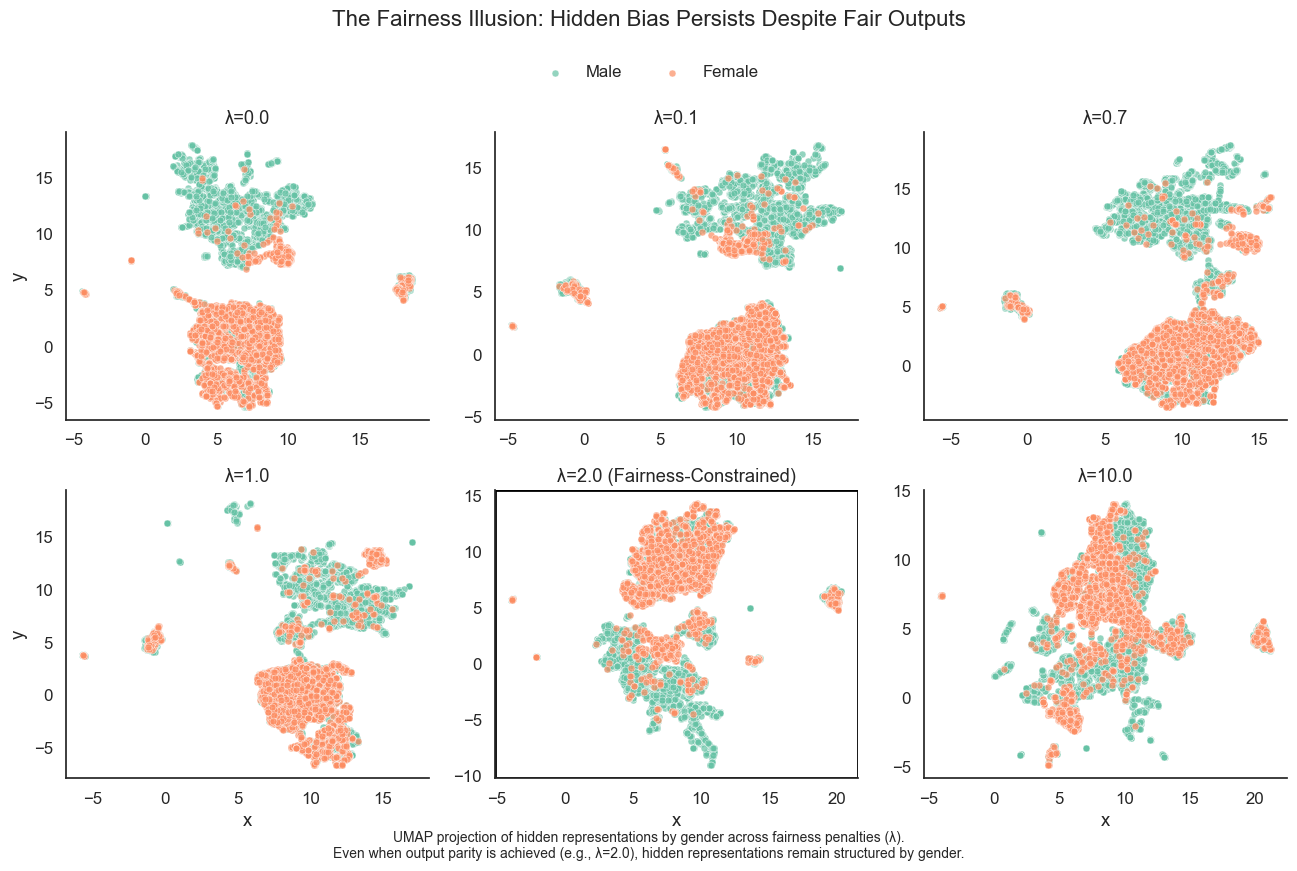

In [32]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

df_all = pd.concat(umap_results, ignore_index=True)

import seaborn as sns
sns.set(style="white", font_scale=1.1)

gender_labels = ["Male" if g == 1 else "Female" for g in sensitive_attr]
highlight_lambda = "λ=2.0"  # or whatever is your main result


g = sns.FacetGrid(df_all, col="lambda", hue="gender", height=4, col_wrap=3, palette="Set2", sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="x", y="y", alpha=0.7, s=25)
g.add_legend(title="Gender")


title_map = {
    f"λ={l}": f"λ={l}" if l != 2.0 else "λ=2.0 (Fairness-Constrained)"
    for l in lambda_list
}
for ax, label in zip(g.axes.flat, g.col_names):
    ax.set_title(title_map[label], fontsize=11)

# Add bounding box highlight around λ=2.0
for ax, title in zip(g.axes.flat, g.col_names):
    if title == highlight_lambda:
        # Highlight box
        ax.add_patch(Rectangle(
            (ax.get_xlim()[0], ax.get_ylim()[0]),
            ax.get_xlim()[1] - ax.get_xlim()[0],
            ax.get_ylim()[1] - ax.get_ylim()[0],
            linewidth=2, edgecolor='black', facecolor='none'
        ))

# After g.map_dataframe(...)
# Update titles cleanly all at once:
new_titles = [t if t != highlight_lambda else f"{highlight_lambda} (Fairness-Constrained)"
              for t in g.col_names]
for ax, new_title in zip(g.axes.flat, new_titles):
    ax.set_title(new_title)

sns.move_legend(
    g, "upper center",
    bbox_to_anchor=(0.5, 1.0),  # push it between figure and title
    ncol=2, title=None, frameon=False
)


# Annotate figure title
plt.suptitle("The Fairness Illusion: Hidden Bias Persists Despite Fair Outputs", fontsize=16, y=1.05)

# Optionally: add caption/annotation outside of plots
plt.figtext(0.5, -0.01,
    "UMAP projection of hidden representations by gender across fairness penalties (λ).\n"
    "Even when output parity is achieved (e.g., λ=2.0), hidden representations remain structured by gender.",
    ha="center", fontsize=10)



plt.tight_layout()
plt.show()

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams['legend.fontsize'] = 29

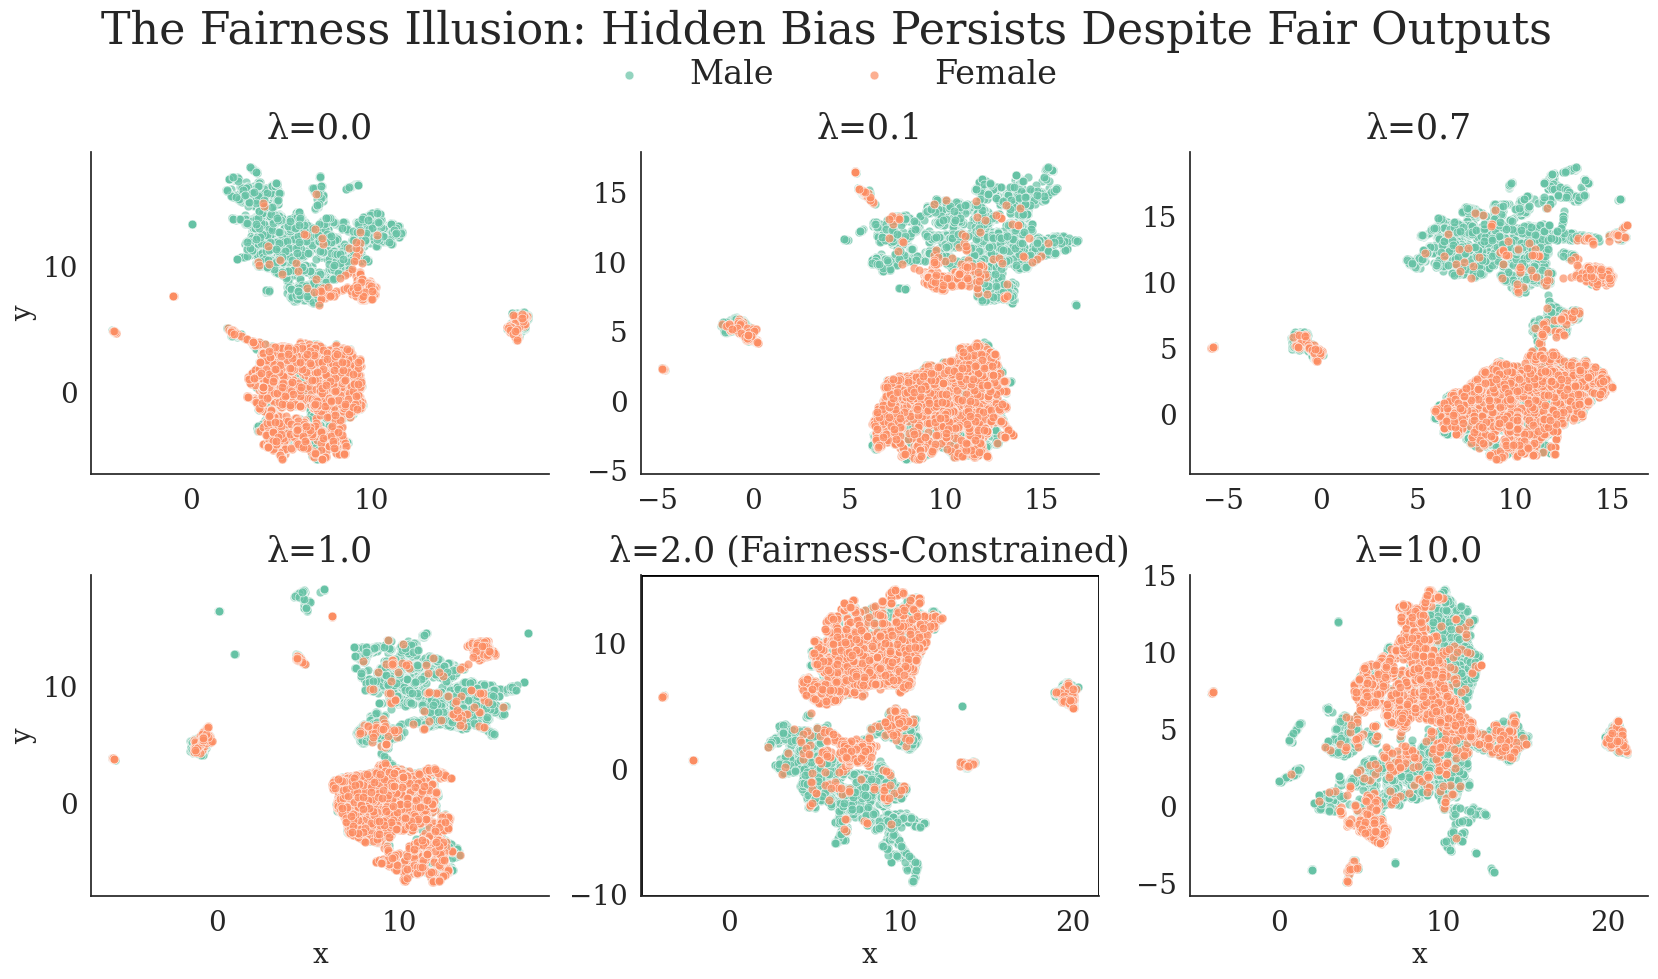

In [54]:
g = sns.FacetGrid(
    df_all, col="lambda", hue="gender", height=4.8, col_wrap=3,
    palette="Set2", sharex=False, sharey=False
)
g.map_dataframe(sns.scatterplot, x="x", y="y", alpha=0.7, s=40)  # bigger dots
g.add_legend(title="Gender")

# Set subplot titles with larger font
for ax, label in zip(g.axes.flat, g.col_names):
    title = f"{label} (Fairness-Constrained)" if label == "λ=2.0" else label
    ax.set_title(title, fontsize=25, pad=10)  # pad lowers the title

# Highlight λ=2.0
for ax, label in zip(g.axes.flat, g.col_names):
    if label == "λ=2.0":
        ax.add_patch(Rectangle(
            (ax.get_xlim()[0], ax.get_ylim()[0]),
            ax.get_xlim()[1] - ax.get_xlim()[0],
            ax.get_ylim()[1] - ax.get_ylim()[0],
            linewidth=2, edgecolor='black', facecolor='none'
        ))

# Move legend under title
sns.move_legend(
    g, "upper center",
    bbox_to_anchor=(0.5, 1.0), ncol=2, title=None, frameon=False
)

# Bigger figure title
# Centered, large title with tighter spacing
plt.subplots_adjust(top=0.88)
plt.suptitle("The Fairness Illusion: Hidden Bias Persists Despite Fair Outputs",
             fontsize=32, y=1.02)
# Caption below
# plt.figtext(0.5, -0.05,
#     "UMAP projection of hidden representations by gender across fairness penalties (λ).\n"
#     "Even when output parity is achieved (e.g., λ=2.0), hidden representations remain structured by gender.",
#     ha="center", fontsize=26)

# High-resolution export option
plt.tight_layout()
plt.savefig("fairness_illusion_umap.png", dpi=300, bbox_inches="tight")
plt.show()